<a href="https://colab.research.google.com/github/dong-gi-jang/binfo/blob/main/Free%202/Free2_Fig5A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free 2
## LIN28A is a suppressor of ER-associated translation in embryonic stem cells
[위 논문](https://doi.org/10.1016/j.cell.2012.10.019)의 Fig.5A (GO enrichment analysis) 재현하기

In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## installation

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

!conda install -y subread

## import dataset

Subread featurecounts이용한 transcript별 read count 계산.

multi-mapping도 고려해야 하는가?
 - ignore all : transcript level에서는 이건 안됨? complete exons would be ignored.[[1]](https://www.sciencedirect.com/science/article/pii/S2001037020303032)
   - 그런데 기존 week1 read-counts.txt 파일은 gene level에서, 이렇게?
 - count once per alignment (-M)
 - equally split (-M --fraction)
   - 그러나 truly expressed gene을 underestimate할 가능성

In [2]:
%cd /content/drive/MyDrive/binfo1-datapack1/

# run subread
# to equally split,
# !featureCounts -a gencode.gtf -o read-counts_es.txt -M --fraction *.bam 

# to ignore,
# !featureCounts -a gencode.gtf -o read-counts.txt *.bam 

/content/drive/MyDrive/binfo1-datapack1


In [3]:
# 우선 ignore 결과인 기존 week1 read-counts.txt 파일 가져와서 진행.
import pandas as pd
import numpy as np
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

## read-counts matrix processing

In [56]:
# 각 컬럼의 sum (total assigned read count)으로 normalize?
# 전체 bam파일 수준에서의 align reads 수로 normalize?

# featurecounts 결과에서의 각 column의 total sum으로 normalize 시도
cnts['log2_clip_enrichment'] = np.log2(   ( cnts['CLIP-35L33G.bam']/cnts['CLIP-35L33G.bam'].sum() )   /   ( cnts['RNA-control.bam']/cnts['RNA-control.bam'].sum() )   )
cnts['log2_rden_change'] = np.log2(  
    (   ( cnts['RPF-siLin28a.bam']/cnts['RPF-siLin28a.bam'].sum() ) / ( cnts['RNA-siLin28a.bam']/cnts['RNA-siLin28a.bam'].sum() )   )
    /
    (   ( cnts['RPF-siLuc.bam']/cnts['RPF-siLuc.bam'].sum() ) / ( cnts['RNA-siLuc.bam']/cnts['RNA-siLuc.bam'].sum() )   )   
    )

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [64]:
# Geneid(index) 마다 있는 점 뒤쪽 제거하여 우선은 gene level에서 보기
import copy

cnts_rmdot = copy.deepcopy(cnts)
cnts_rmdot.index = cnts_rmdot.index.map(lambda p : p.split('.')[0])

In [60]:
# cutoff 정해, low abundant 제거하기
# 논문 따라하려면 어떻게?
# exclude transcripts with low ribosome occupancy(<80 raw reads in siLuc) 즉, RPF-siLuc >80
rna_cutoff = 30
ribo_cutoff = 80

ribobool = cnts_rmdot['RPF-siLuc.bam'] > ribo_cutoff
rnabool = cnts_rmdot['RNA-siLuc.bam'] > rna_cutoff
lin28abool = cnts_rmdot['RNA-siLin28a.bam'] > rna_cutoff

# clipbool = cnts_rmdot['RNA-control.bam'] > rna_cutoff

cnts_cutoff = cnts_rmdot[ribobool & rnabool & lin28abool]

In [61]:
# log2 처리 시 nan값, -inf값 포함 여부 확인
print('nan # : ',len(cnts_cutoff[cnts_cutoff['log2_clip_enrichment'].isnull() | cnts_cutoff['log2_rden_change'].isnull()]))
print('-inf # : ', len(cnts_cutoff[(cnts_cutoff['log2_clip_enrichment']==-np.inf) | (cnts_cutoff['log2_rden_change']==-np.inf) ]))

nan # :  0
-inf # :  4


In [62]:
# -inf값 4개 있어서, 제거된 df 이용
cnts_noinf = cnts_cutoff[cnts_cutoff['log2_clip_enrichment']!=-np.inf]

In [65]:
# matrix에 포함된 gene 목록 추출
raw_genelist= cnts_noinf.index.tolist()
# 중복된 gene 여부 확인
print(len(raw_genelist),len(set(raw_genelist)))

8070 8070


## Identifier mapping

In [ ]:
# EnsEMBL Gene ID를 gene symbol, uniprot accession으로 mapping 위해,
!pip install gseapy

In [11]:
import gseapy as gp
bm = gp.parser.Biomart()

Creating directory /root/.config/bioservices 
Creating directory /root/.cache/bioservices 
Welcome to Bioservices
It looks like you do not have a configuration file.
We are creating one with default values in /root/.config/bioservices/bioservices.cfg .
Done


In [14]:
# M.musculus dataset에 대해서 가져올 수 있는 attributes 목록 확인해보기
attributetable = bm.get_attributes('mmusculus_gene_ensembl')
attributetable

,Attribute,Description
0,ensembl_gene_id,Gene stable ID
1,ensembl_gene_id_version,Gene stable ID version
2,ensembl_transcript_id,Transcript stable ID
3,ensembl_transcript_id_version,Transcript stable ID version
4,ensembl_peptide_id,Protein stable ID
...,...,...
2875,cdna,cDNA sequences
2876,coding,Coding sequence
2877,peptide,Peptide
2878,upstream_flank,upstream_flank


In [15]:
# GO term 관련 attribute 확인
attributetable[attributetable['Description'].str.contains('GO')]

,Attribute,Description
41,go_id,GO term accession
42,name_1006,GO term name
43,definition_1006,GO term definition
44,go_linkage_type,GO term evidence code
45,namespace_1003,GO domain
46,goslim_goa_accession,GOSlim GOA Accession(s)
47,goslim_goa_description,GOSlim GOA Description


In [66]:
# GO id, GO domain, GO tern name 가져올 수 있음 확인. 이것 이용하여 GO:CC customize하여 처리할 예정.
# ID 매핑 진행
mapped =  bm.query(dataset='mmusculus_gene_ensembl',attributes=['ensembl_gene_id','external_gene_name','go_id','namespace_1003','name_1006'],filters={'ensembl_gene_id':raw_genelist})

In [67]:
mapped.shape

(488646, 5)

In [68]:
# 생각보다 행의 값 전체가 중복되는 행들 많음. 제거.
mapped_nodup = mapped.drop_duplicates(['ensembl_gene_id','external_gene_name','go_id','namespace_1003','name_1006'])
mapped_nodup.shape

(165389, 5)

In [69]:
# 넣어준 genelist 전부 mapping되었는지, 개수 한 번 확인
len(set(mapped_nodup['ensembl_gene_id'].tolist()))

8070

## Define categorial terms

In [76]:
# GO domain 별 table 분리
GOCC = mapped_nodup[mapped_nodup['namespace_1003']=='cellular_component']
GOMF = mapped_nodup[mapped_nodup['namespace_1003']=='molecular_function']
GOBP = mapped_nodup[mapped_nodup['namespace_1003']=='biological_process']
print('GOCC # : ', len(GOCC), '\nGOMF # : ', len(GOMF), '\nGOBP # : ', len(GOBP))

GOCC # :  49070 
GOMF # :  38367 
GOBP # :  70999


- figure엔 mitochondrion 있지만, method엔 mitochondrion 안 써있음. 이유?
- 논문에서는 GO:0031966(mitochondrial membrane)에 대한 각 term의 차집합을 이용함. 이유는?


## categorial term. 수정 필요. 이용할 지 말지도 결정

In [71]:
# 논문 method 참고, categorial term 설정. 전부 GO:CC 관련 term들. 
ccdict = {'mitochondrial_membrane':'GO:0031966',  
          'nucleus':'GO:0005634', 
          'integral_component_of_membrane':'GO:0016021',
          'cytoplasm':'GO:0005737',
          'extracellular_region':'GO:0005576',
          'cell_surface':'GO:0009986',
          'Golgi_apparatus':'GO:0005794',
          'endoplasmic_reticulum':'GO:0005783',
          'mitochondrion':'GO:0005739'
          }
for i,j in ccdict.items():
  globals()['gocc_{}'.format(i)] = GOCC[GOCC['go_id']==j]
  globals()['gocc_{}_unique'.format(i)] = set(globals()['gocc_{}'.format(i)]['ensembl_gene_id'].tolist())

In [72]:
# mitochondrial membrane term과 각 term이 얼마나 겹치는 게 많은지부터 확인.
cclist = list(ccdict)

print('mitochondrial_membrane : ', len(gocc_mitochondrial_membrane_unique))

for i in cclist:
  if i!='mitochondrial_membrane':
    print()
    print(i,':', len(globals()['gocc_{}_unique'.format(i)]))
    print('intersection :',len(globals()['gocc_{}_unique'.format(i)] & gocc_mitochondrial_membrane_unique))

mitochondrial_membrane :  116

nucleus : 3461
intersection : 26

integral_component_of_membrane : 1680
intersection : 76

cytoplasm : 3605
intersection : 29

extracellular_region : 286
intersection : 4

cell_surface : 225
intersection : 3

Golgi_apparatus : 712
intersection : 3

endoplasmic_reticulum : 867
intersection : 21

mitochondrion : 1193
intersection : 107


In [73]:
# 각각의 customized GOCC term에 맞는 genelist 할당
# nucleus - mito mem
# integral mem - mito mem
# cytoplasm - mito mem
# ER associated : integral mem + extracell + surface + golgi + er - mito mem
# non ER : total - ER associated - mito mem

gocc_final_unique_nucleus = gocc_nucleus_unique - gocc_mitochondrial_membrane_unique
gocc_final_unique_integral_component_of_membrane = gocc_integral_component_of_membrane_unique - gocc_mitochondrial_membrane_unique
gocc_final_unique_cytoplasm = gocc_cytoplasm_unique - gocc_mitochondrial_membrane_unique
gocc_final_unique_ER =  (gocc_integral_component_of_membrane_unique | gocc_extracellular_region_unique | gocc_cell_surface_unique | gocc_Golgi_apparatus_unique | gocc_endoplasmic_reticulum_unique) - gocc_mitochondrial_membrane_unique
gocc_final_unique_nonER = (totalgenelist - gocc_final_unique_ER) - gocc_mitochondrial_membrane_unique


## GOCC table 전체 그냥 이용하는 방법 
 - 이 방법에서는 GO CC MF BP 나눌 필요 없을 듯.

In [ ]:
# 각 GO term별, match된 input dataset 내 gene 수 
# 각 GO term을 구성하는 gene 정보를 가져오지 않았기 때문에, overlap은 계산할 수 없음. 단지 count만.
# GO term 자체의 hierarchy 높을수록 구성 gene 수 많을 텐데.

count={}
lists = mapped_nodup['go_id'].tolist()
for i in lists:
    try: count[i] += 1
    except: count[i]=1
print(count)

In [87]:
# 내림차순 정렬
sorted_count = sorted(count.items(), key = lambda item: item[1],reverse=True)

- ensembl, logC, logR : cnts_noinf
- ensembl, GO ID : mapped_nodup
- GO ID sorted : sorted_count

In [84]:
!pip install tqdm
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Statistical test

In [91]:
# GO term count 높은 것부터 순서대로,
# 각 GO term의 member와 member 제외 전체 gene들의 log2 C, R 가져오기
from scipy import stats

stat_result = pd.DataFrame(columns=['GO-term','count','CLIP_mean','Rden_mean','Clip_p-value','Rden_p-value'])
for i,j in tqdm(sorted_count[1:]): #index 0은 nan이라 무시함.
  temp_genelist = mapped_nodup[mapped_nodup['go_id']==i]['ensembl_gene_id'].tolist()
  gomember = cnts_noinf[cnts_noinf.index.isin(temp_genelist)]
  others =  cnts_noinf[~cnts_noinf.index.isin(temp_genelist)]

  logC_avg = np.mean(gomember['log2_clip_enrichment'])
  logR_avg = np.mean(gomember['log2_rden_change'])


  Clip_pvalue = list(stats.mannwhitneyu(gomember['log2_clip_enrichment'],others['log2_clip_enrichment']))[1]
  Rden_pvalue = list(stats.mannwhitneyu(gomember['log2_rden_change'],others['log2_rden_change']))[1]

  row = [i,j,logC_avg, logR_avg, Clip_pvalue, Rden_pvalue ]
  stat_result = stat_result.append(pd.Series(row, index=stat_result.columns), ignore_index=True)

100%|██████████| 14593/14593 [07:24<00:00, 32.84it/s]


In [96]:
# Clip enrichment p-value -> FDR  위해, 오름차순 정렬
stat_result_clipp_sorted = stat_result.sort_values('Clip_p-value')

In [97]:
# p-value 같은 값 있어도, 다음 rank는 1만 증가시키는 방법(dense) 이용?
# https://stats.stackexchange.com/questions/18872/how-to-deal-with-identical-p-values-with-the-benjamini-hochberg-method-for-corre
stat_result_clipp_sorted['Clip_p-value_rank'] = stat_result_clipp_sorted['Clip_p-value'].rank(method='dense')

In [98]:
# 대안) FDR 계산 R package 이용해서 한 번에 진행하는 방법
# https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ossiriand&logNo=220860705917
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

p_adjust = stats.p_adjust(FloatVector(stat_result_clipp_sorted['Clip_p-value']), method = 'BH')

In [99]:
stat_result_clipp_sorted['Clip_FDR']=list(p_adjust)

In [100]:
# 오래걸리니까 일단 저장
stat_result_clipp_sorted.to_csv('./total_result_clipfdr.csv')

In [122]:
# FDR 0.05 cutoff
stat_result_fdr = stat_result_clipp_sorted[stat_result_clipp_sorted['Clip_FDR']<0.05]
stat_result_fdr.head()

,GO-term,count,CLIP_mean,Rden_mean,Clip_p-value,Rden_p-value,Clip_p-value_rank,Clip_FDR
6,GO:0016021,1680,0.116223,0.315096,1.033685e-146,0.000000e+00,1.0,1.508456e-142
3,GO:0016020,2762,-0.212355,0.043605,4.822372e-83,1.897114e-240,2.0,3.518643e-79
13,GO:0005783,867,0.052653,0.185614,6.683996e-56,3.370508e-121,3.0,3.251318e-52
27,GO:0005789,511,0.198027,0.280129,1.521795e-45,1.523852e-100,4.0,5.551888e-42
85,GO:0005887,220,0.365967,0.440608,1.853590e-29,1.091285e-67,5.0,5.409888e-26


In [126]:
# GO domain 및 term name mapping
godomain_term = mapped_nodup.drop_duplicates(['go_id'])

finaltable = stat_result_fdr.join(godomain_term.set_index('go_id')[['namespace_1003','name_1006']], on='GO-term')

## enrichr (일단 사용 안함)


In [ ]:
# enrichr
# GO database 가져오기
mouselib = gp.get_library_name(organism='Mouse')
mousegolib = [s for s in mouselib if "GO" in s] 
mousegolib2021 = [s for s in mousegolib if "2021" in s]
mousegolib2021

['GO_Biological_Process_2021',
 'GO_Cellular_Component_2021',
 'GO_Molecular_Function_2021']

In [ ]:
# enrichr
# gene_sets 리스트로 넣어주면 왜 한 종류만 나올까. 지난 번 수업 시간에 KEGG 했을때도 다시보니 한종류 geneset만 결과 나왔었더라.
# 따로따로 testing해서 테이블 이어 붙혀도 상관 없나.
enrcc= gp.enrichr(gene_list = upreg_genenames, gene_sets=mousegolib2021[1],organism='Mouse',description='',outdir='test/enrichr_go2021',cutoff=0.05)
enrmf= gp.enrichr(gene_list = upreg_genenames, gene_sets=mousegolib2021[2],organism='Mouse',description='',outdir='test/enrichr_go2021',cutoff=0.05)
enrbp= gp.enrichr(gene_list = upreg_genenames, gene_sets=mousegolib2021[0],organism='Mouse',description='',outdir='test/enrichr_go2021',cutoff=0.05)

In [ ]:
# enrichr
enrconcat = pd.concat([enrbp.res2d,enrcc.res2d,enrmf.res2d])
enrconcat

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,mRNA processing (GO:0006397),267/300,2.928254e-70,1.707172e-66,0,0,12.328116,1.973812e+03,TCERG1;RAMAC;CCNH;EIF4A3;GPATCH1;HNRNPU;HNRNPR...
1,GO_Biological_Process_2021,"mRNA splicing, via spliceosome (GO:0000398)",245/274,1.773668e-65,5.170242e-62,0,0,12.840775,1.914495e+03,EIF4A3;GPATCH1;HNRNPU;HNRNPR;WDR83;CCAR1;PNN;S...
2,GO_Biological_Process_2021,"RNA splicing, via transesterification reaction...",227/251,6.157058e-63,9.679117e-60,0,0,14.349037,2.055432e+03,EIF4A3;GPATCH1;HNRNPU;HNRNPR;WDR83;CCAR1;PNN;S...
3,GO_Biological_Process_2021,rRNA processing (GO:0006364),170/173,6.640904e-63,9.679117e-60,0,0,85.498334,1.224076e+04,RPL4;POP5;RPL5;RPL30;RPL3;RPL32;RPL31;POP4;RPL...
4,GO_Biological_Process_2021,ribosome biogenesis (GO:0042254),184/192,6.307342e-62,7.354361e-59,0,0,34.749271,4.896817e+03,LTV1;RPL4;POP5;RPL5;RPL30;RPL3;RPL32;RPL31;POP...
...,...,...,...,...,...,...,...,...,...,...
1163,GO_Molecular_Function_2021,chemokine receptor binding (GO:0042379),1/50,9.999964e-01,9.999968e-01,0,0,0.030031,1.084362e-07,ITCH
1164,GO_Molecular_Function_2021,CCR chemokine receptor binding (GO:0048020),1/42,9.999966e-01,9.999968e-01,0,0,0.035915,1.218540e-07,CNIH4
1165,GO_Molecular_Function_2021,steroid hydroxylase activity (GO:0008395),1/36,9.999968e-01,9.999968e-01,0,0,0.042093,1.352583e-07,CYP2S1
1166,GO_Molecular_Function_2021,neuropeptide receptor activity (GO:0008188),1/30,9.999968e-01,9.999968e-01,0,0,0.050827,1.612278e-07,SSTR2


## visualize
- bubble size는 overlap ratio 아닌 count로.
- GO term 내 transcript들의 FDR이 0.05 미만인 것으로 cutoff 정한 후,
- 하위 subset terms were omitted. (지금은 x)



In [150]:
finaltable.sort_values('count')[-20:]

,GO-term,count,CLIP_mean,Rden_mean,Clip_p-value,Rden_p-value,Clip_p-value_rank,Clip_FDR,namespace_1003,name_1006
64,GO:0005576,286,0.054802,0.264872,1.031876e-19,6.157749e-51,9.0,1.673130e-16,cellular_component,extracellular region
44,GO:0030054,364,-0.331819,-0.232428,3.777033e-05,3.437345e-01,87.0,6.335430e-03,cellular_component,cell junction
39,GO:0005743,373,-0.858004,-0.104303,2.187599e-05,9.886767e-10,74.0,4.314003e-03,cellular_component,mitochondrial inner membrane
27,GO:0005789,511,0.198027,0.280129,1.521795e-45,1.523852e-100,4.0,5.551888e-42,cellular_component,endoplasmic reticulum membrane
22,GO:0043231,598,-0.397214,-0.173574,2.016062e-04,2.433157e-04,120.0,2.431437e-02,cellular_component,intracellular membrane-bounded organelle
20,GO:0003723,669,-0.741461,-0.563381,4.020453e-04,1.385347e-45,150.0,3.853740e-02,molecular_function,RNA binding
19,GO:0005794,712,-0.179972,-0.018478,1.424003e-19,2.088116e-29,10.0,2.078048e-16,cellular_component,Golgi apparatus
18,GO:0005856,732,-0.733063,-0.484213,4.935699e-04,9.142376e-27,163.0,4.391870e-02,cellular_component,cytoskeleton
16,GO:0003677,805,-0.773198,-0.513746,2.626590e-06,4.388508e-39,53.0,7.232044e-04,molecular_function,DNA binding
13,GO:0005783,867,0.052653,0.185614,6.683996e-56,3.370508e-121,3.0,3.251318e-52,cellular_component,endoplasmic reticulum


In [186]:
# membrane, integral component of membrane 등 크게 의미 없는 term들
# manually 제외 필요?

excllist = ['membrane','nucleoplasm','integral component of membrane','identical protein binding','nucleotide binding','DNA binding','cytosol']
pltinput = finaltable[~finaltable['name_1006'].isin(excllist)]

NameError: ignored

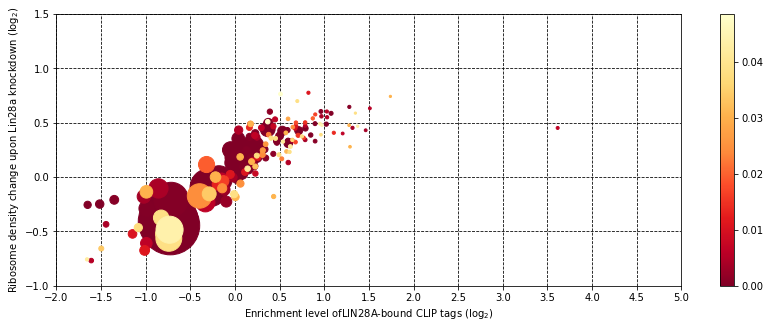

In [161]:
# visulaize
# 우선 최대한 파이썬의 scatter(bubble plot) 등으로 표현해보기
# 각 bubble 주변에 label(말풍선 및 화살표) 적절히 놓을 수 있는 방법? 
# plt fig ax, subplot 사용?
from matplotlib import pyplot as plt
plt.figure(figsize=(14,5))
plt.xlabel('Enrichment level ofLIN28A-bound CLIP tags ($\log_2$)')
plt.ylabel('Ribosome density change upon Lin28a knockdown ($\log_2$)')
plt.xlim(-2,5)
plt.ylim(-1,1.5)
plt.xticks(np.arange(-2, 5.01, step=0.5))
plt.yticks(np.arange(-1, 1.51, step=0.5))
plt.grid(True, color='black', linestyle='--',linewidth=0.8)
plt.scatter(pltinput['CLIP_mean'],  pltinput['Rden_mean'],  s=pltinput['count'].tolist(),  c=pltinput['Clip_FDR'].tolist(),  cmap='YlOrRd_r', zorder=3)
plt.colorbar()
b.ax.set_ylabel('Term-specific enrichment confidence (false discovery rate)', rotation=90, labelpad = -60)
b.ax.set_yticklabels([10**-20,10**-18,10**-16,10**-14,10**-12,10**-10,10**-8,10**-6,10**-4,10**-2,10**-0])
None

In [187]:
# 연습
pltinput = pltinput.sort_values('Clip_FDR',ascending=False)

In [188]:
pltinput.sort_values('count',ascending=False)[:20]

,GO-term,count,CLIP_mean,Rden_mean,Clip_p-value,Rden_p-value,Clip_p-value_rank,Clip_FDR,namespace_1003,name_1006
0,GO:0005737,3605,-0.747412,-0.409588,9.191898e-27,2.074356e-96,6.0,2.235623e-23,cellular_component,cytoplasm
1,GO:0005634,3461,-0.724884,-0.444662,1.080217e-16,2.078486e-133,14.0,1.125972e-13,cellular_component,nucleus
8,GO:0005886,1461,-0.289496,-0.097220,1.160209e-24,1.639025e-29,8.0,2.116366e-21,cellular_component,plasma membrane
9,GO:0005739,1193,-0.715741,-0.206784,1.547725e-06,1.210991e-05,47.0,4.805522e-04,cellular_component,mitochondrion
13,GO:0005783,867,0.052653,0.185614,6.683996e-56,3.370508e-121,3.0,3.251318e-52,cellular_component,endoplasmic reticulum
18,GO:0005856,732,-0.733063,-0.484213,4.935699e-04,9.142376e-27,163.0,4.391870e-02,cellular_component,cytoskeleton
19,GO:0005794,712,-0.179972,-0.018478,1.424003e-19,2.088116e-29,10.0,2.078048e-16,cellular_component,Golgi apparatus
20,GO:0003723,669,-0.741461,-0.563381,4.020453e-04,1.385347e-45,150.0,3.853740e-02,molecular_function,RNA binding
22,GO:0043231,598,-0.397214,-0.173574,2.016062e-04,2.433157e-04,120.0,2.431437e-02,cellular_component,intracellular membrane-bounded organelle
27,GO:0005789,511,0.198027,0.280129,1.521795e-45,1.523852e-100,4.0,5.551888e-42,cellular_component,endoplasmic reticulum membrane


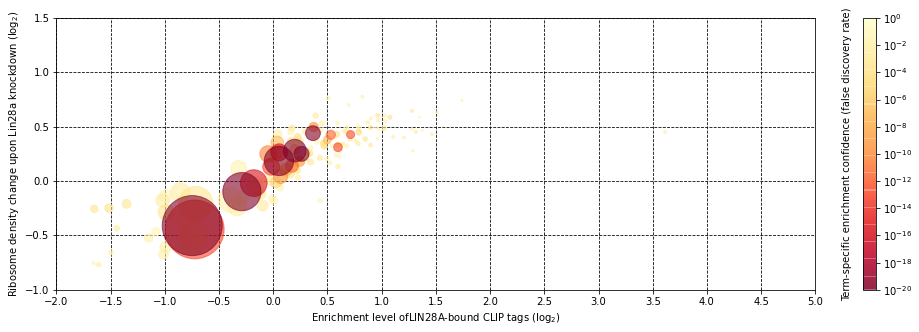

In [192]:
# 연습
# 진한, 중요한 bubble이 앞에 오도록 문제 해결 필요. : pltinput 색 진하기(fdr) 역순으로 정렬 후 scatter? -> 맞다.
# cytoplam, nucleus 비슷한 위치인데 크기도 너무 큼 : mito membrane 제거해도 크게 도움될 것 같지는 않다.
# dual localization 갖는 protein 많아서 ?
from matplotlib import pyplot as plt
import matplotlib.colors as colors

plt.figure(figsize=(17,5))
plt.xlabel('Enrichment level ofLIN28A-bound CLIP tags ($\log_2$)')
plt.ylabel('Ribosome density change upon Lin28a knockdown ($\log_2$)')
plt.xlim(-2,5)
plt.ylim(-1,1.5)
plt.xticks(np.arange(-2, 5.01, step=0.5))
plt.yticks(np.arange(-1, 1.51, step=0.5))
plt.grid(True, color='black', linestyle='--',linewidth=0.8)
plt.scatter(pltinput['CLIP_mean'],  pltinput['Rden_mean'],  s=pltinput['count'].tolist(),  c=pltinput['Clip_FDR'].tolist(), norm=colors.LogNorm(vmin=10**-20, vmax=1), cmap='YlOrRd_r', alpha=0.6,zorder=3)
b = plt.colorbar()
b.ax.set_ylabel('Term-specific enrichment confidence (false discovery rate)', rotation=90, labelpad = -70)
b.set_ticks([10**-0, 10**-2,10**-4,10**-6,10**-8,10**-10,10**-12,10**-14,10**-16,10**-18,10**-20])
None